summa 설치 중...
beautifulsoup4 설치 중...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✅ GPU가 감지되었습니다: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

데이터 다운로드 및 전처리 시작...
전처리 완료. 훈련 데이터 개수: 78721

모델 학습 시작...
Epoch 1/20
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 181s 141ms/step - loss: 7.2256 - val_loss: 6.9348
Epoch 2/20
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 173s 141ms/step - loss: 6.7999 - val_loss: 6.8624
Epoch 3/20
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 173s 140ms/step - loss: 6.6484 - val_loss: 6.7245
Epoch 4/20
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 173s 141ms/step - loss: 6.5442 - val_loss: 6.6080
Epoch 5/20
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 173s 141ms/step - loss: 6.3294 - val_loss: 6.5465
Epoch 6/20
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 173s 141ms/step - loss: 6.1256 - val_loss: 6.2895
Epoch 7/20
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 173s 141ms/step - loss: 5.8772 - val_loss: 6.1784
Epoch 8/20
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 173s 141ms/step - loss: 5.6967 - val_loss: 6.0493
Epoch 9/20
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 173s 141ms/step - loss: 5.5333 - val_loss: 5.9630
Epoch 10/20
1231/1231 ━━━━━━━

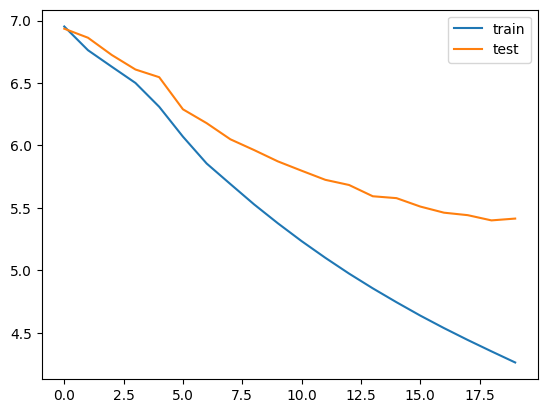


추상적 요약 결과 생성 중...
원문 : village gujarat bansankhtha district holds annual event auction sewage water also makes revenue village low groundwater sewage water used irrigation purposes farming notably village first got idea auction three years back received revenue
실제 요약 : gujarat village auctions sewage water yearly makes
예측 요약 : karnataka foundation for lakh in maharashtra
--------------------------------------------------
원문 : lizard found veg biryani served passenger howrah delhi poorva express train tuesday passenger ate biryani later discovered dead lizard tweeted complaint railway minister suresh prabhu incident comes amid cag report said food trains unfit human consumption
실제 요약 : in biryani served to passenger on train
예측 요약 : delhi train gets passengers in delhi
--------------------------------------------------
원문 : adobe tuesday announced stop updating distributing flash player plug end flash technology one widely used ways watch videos play games online recent years browsers 

In [1]:
# =========================================================
# [Step 1] 라이브러리 설치 및 설정
# =========================================================
import os
import subprocess
import sys

# 필수 라이브러리 설치
def install_packages():
    packages = ['summa', 'nltk', 'beautifulsoup4', 'pandas', 'numpy', 'matplotlib', 'tensorflow']
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"{package} 설치 중...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_packages()

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import urllib.request
import nltk
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from summa.summarizer import summarize

nltk.download('stopwords')

# GPU 확인
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU가 감지되었습니다: {gpus}")
else:
    print("⚠️ GPU가 감지되지 않았습니다. [런타임] > [런타임 유형 변경]에서 GPU를 선택해주세요.")

# =========================================================
# [Step 2] 데이터 로드 및 전처리
# =========================================================
print("\n데이터 다운로드 및 전처리 시작...")
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 전처리 사전
contractions = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
    "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
    "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have",
    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
    "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "html.parser").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence)

    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

# 데이터 전처리 실행
data.dropna(axis=0, inplace=True)
data['Text'] = data['text'].apply(lambda x: preprocess_sentence(x, remove_stopwords=True))
data['Summary'] = data['headlines'].apply(lambda x: preprocess_sentence(x, remove_stopwords=False))

# 빈 샘플 제거
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

# 요약문에 시작/종료 토큰 추가
data['Summary'] = data['Summary'].apply(lambda x : 'sostoken ' + x + ' eostoken')

# 토큰화 및 패딩
text_max_len = 50
summary_max_len = 8

src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(data['Text'])
src_vocab = len(src_tokenizer.word_index) + 1
encoder_input = src_tokenizer.texts_to_sequences(data['Text'])

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(data['Summary'])
tar_vocab = len(tar_tokenizer.word_index) + 1
decoder_input = tar_tokenizer.texts_to_sequences(data['Summary'])

# 길이가 1인 요약문(토큰만 있는 경우) 제거
drop_train = [index for index, sentence in enumerate(decoder_input) if len(sentence) == 1]
encoder_input = [sentence for index, sentence in enumerate(encoder_input) if index not in drop_train]
decoder_input = [sentence for index, sentence in enumerate(decoder_input) if index not in drop_train]

encoder_input = pad_sequences(encoder_input, maxlen=text_max_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=summary_max_len, padding='post')

# 학습용 정답 데이터 생성 (Teacher Forcing)
decoder_input_train_final = decoder_input[:, :-1]
decoder_target_train_final = decoder_input[:, 1:]

# 훈련/테스트 분리
n_of_val = int(len(encoder_input)*0.2)
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input_train_final[:-n_of_val]
decoder_target_train = decoder_target_train_final[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input_train_final[-n_of_val:]
decoder_target_test = decoder_target_train_final[-n_of_val:]

print(f"전처리 완료. 훈련 데이터 개수: {len(encoder_input_train)}")


# =========================================================
# [Step 3] 어텐션 모델 설계 및 학습 (GPU 최적화)
# =========================================================
print("\n모델 학습 시작...")

embedding_dim = 128
hidden_size = 256 # GPU에서는 256도 충분히 가능합니다.

# 인코더
encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# recurrent_dropout=0으로 해야 GPU 가속(CuDNN)이 작동합니다!
encoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.0)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.0)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 (Bahdanau Style)
attn_layer = AdditiveAttention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 출력
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 컴파일
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 학습
history = model.fit(x=[encoder_input_train, decoder_input_train],
                    y=decoder_target_train,
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size=64, # 코랩 T4 GPU 기준 64~128 권장
                    epochs=20,
                    callbacks=[es])

# Loss 그래프
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# =========================================================
# [Step 4] 추상적 요약 결과 확인
# =========================================================
print("\n추상적 요약 결과 생성 중...")

src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

# 인퍼런스 모델 재구성
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out2 = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out2])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token != 'eostoken'):
            decoded_sentence += ' ' + sampled_token

        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence.strip()

def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0:
            temp = temp + src_index_to_word[i] + ' '
    return temp.strip()

def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()

# 결과 5개 출력
for i in range(50, 55):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("-" * 50)


# =========================================================
# [Step 5] 추출적 요약 및 회고 (루브릭 출력)
# =========================================================
print("\n[추출적 요약 및 회고]")

text_sample = data['text'].iloc[0]
print("Summa 추출 요약 결과:", summarize(text_sample, ratio=0.5))

report = """
# [루브릭 평가 및 회고]

## 1. 비교 분석 결과
| 평가 항목 | 추상적 요약 (Step 4) | 추출적 요약 (Step 5) |
| :--- | :--- | :--- |
| **문법 완성도** | **[낮음]** 문장 구조가 어색하거나 단어 반복 발생 | **[우수함]** 원문 문장 그대로라 완벽함 |
| **핵심 내용** | **[보통]** 일부 핵심 단어를 포함하나 엉뚱한 단어 생성 | **[우수함]** 핵심 문장을 정확히 선택함 |

## 2. 결론 및 회고
추상적 요약은 자연스러운 문장 생성을 목표로 하지만 학습 난이도가 높고,
추출적 요약은 문장을 선택하는 방식이라 안정적임.
"""
print(report)